# Autoencoder
In the following notebook, we will use an Autoencoder for the tasks of feature extraction and dimensionality reduction on the MNIST dataset.  
Autoencoders are a type of generative neural network employed to recreate a given input, encoding the input data and extracting the most valuable information from it.
An autoencoder consists of two parts: an encoder, which compresses the input data, and a decoder, which decodes the compressed representation of the data to recreate the input as closely as possible with minimal loss of information.

<hr>


## Building the model
In this example we will be using the MNIST dataset

Let's call our imports and make the MNIST data available to use.


In [2]:
!pip install tensorflow==2.9.0

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Data Normalization

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [7]:
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [9]:
x_image_test = tf.reshape(x_test, [-1, 28, 28, 1])
x_image_test = tf.cast(x_image_test, 'float32')

In [10]:
print(x_train.shape)

(60000, 28, 28)


We flatten the data to be compatible with encoding and decoding layers

In [11]:
flatten_layer = tf.keras.layers.Flatten()
x_train = flatten_layer(x_train)

Notice how the <code>x_train.shape</code> has changed from (60000,28,28) to (60000, 784)

In [12]:
print(x_train.shape)

(60000, 784)


Now, let's define the parameters that our NN is going to use

In [13]:
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10
global_step = tf.Variable(0)
total_batch = int(len(x_train) / batch_size)

# Network Parameters
n_hidden_1 = 256
n_hidden_2 = 128
encoding_layer = 32  # final encoding bottleneck features
n_input = 784

### Encoder
Now we will create our encoder using the Sigmoid activation function


In [14]:
encoding_1 = tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid)
encoding_2 = tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.sigmoid)
encoding_final = tf.keras.layers.Dense(encoding_layer, activation=tf.nn.relu)


def encoder(x):
    x_reshaped = flatten_layer(x)
    layer_1 = encoding_1(x_reshaped)
    layer_2 = encoding_2(layer_1)
    code = encoding_final(layer_2)
    return code

### Decoder
We can see that the layers are in reverse order. The layer_1 in the encoder is the layer_2 in the decoder and vice-versa

In [15]:
decoding_1 = tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.sigmoid)
decoding_2 = tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid)
decoding_final = tf.keras.layers.Dense(n_input)


def decoder(x):
    layer_1 = decoding_1(x)
    layer_2 = decoding_2(layer_1)
    decode = decoding_final(layer_2)
    return decode

## Custom model

Let's construct our model.
We  define a <code>cost</code> function to calculate the loss  and a <code>grad</code> function to calculate gradients that will be used in backpropagation.


In [16]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.encoding_layer = encoding_layer
        self.n_input = n_input

        self.flatten_layer = tf.keras.layers.Flatten()
        self.enocoding_1 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.encoding_2 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.encoding_final = tf.keras.layers.Dense(self.encoding_layer, activation=tf.nn.relu)
        self.decoding_1 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.decoding_2 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.decoding_final = tf.keras.layers.Dense(self.n_input)

    def encoder(self, x):
        layer_1 = self.enocoding_1(x)
        layer_2 = self.encoding_2(layer_1)
        code = self.encoding_final(layer_2)
        return code

    def decoder(self, x):
        layer_1 = self.decoding_1(x)
        layer_2 = self.decoding_2(layer_1)
        decode = self.decoding_final(layer_2)
        return decode

    def call(self, x):
        encoder_op = self.encoder(x)
        # Reconstructed Images
        y_pred = self.decoder(encoder_op)
        return y_pred


def cost(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    cost = tf.reduce_mean(loss)
    return cost


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        reconstruction = model(inputs)
        loss_value = cost(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

### Training

We will run 20 epochs for training

In [17]:
model = AutoEncoder()
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

for epoch in range(training_epochs):
    for i in range(total_batch):
        x_inp = x_train[i: i + batch_size]
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0:
        print("Epoch:", '%02d' % (epoch+1),
              "cost=", "{:.9f}".format(loss_value))

print("Optimization Finished!")

Epoch: 01 cost= 0.046973951
Epoch: 02 cost= 0.033073090
Epoch: 03 cost= 0.025245123
Epoch: 04 cost= 0.019906206
Epoch: 05 cost= 0.018899206
Epoch: 06 cost= 0.016197808
Epoch: 07 cost= 0.014060482
Epoch: 08 cost= 0.012603205
Epoch: 09 cost= 0.011441148
Epoch: 10 cost= 0.010627277
Epoch: 11 cost= 0.009625590
Epoch: 12 cost= 0.009513579
Epoch: 13 cost= 0.008849796
Epoch: 14 cost= 0.008350188
Epoch: 15 cost= 0.007873964
Epoch: 16 cost= 0.007685808
Epoch: 17 cost= 0.007260828
Epoch: 18 cost= 0.006985208
Epoch: 19 cost= 0.006713427
Epoch: 20 cost= 0.006468055
Optimization Finished!


Now, let's apply encoder and decoder for our tests.


In [18]:
encode_decode = model(flatten_layer(x_image_test[:examples_to_show]))

Let's simply visualize the graphs. The following snippet compares the original images with ther reconstructions

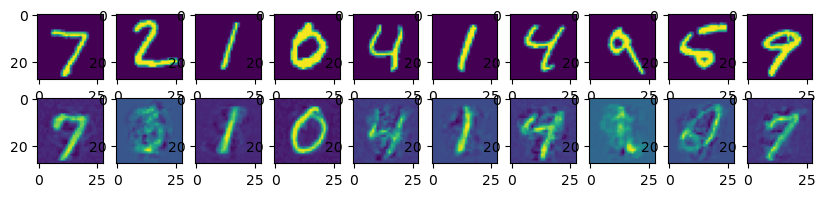

In [19]:
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_image_test[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))

As observed, the reconstructions were pretty successful. It can be noted that some noise was added to each image

### Image Denoising
Another function of Autoencoders is to remove noise from images. In the following section, we create a noisy version of the dataset by applying random noise to each image

In [31]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [32]:
noise_factor = 0.2
x_train_noise = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noise = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noise = tf.clip_by_value(x_train_noise, clip_value_min=0., clip_value_max=1.)
x_test_noise = tf.clip_by_value(x_test_noise, clip_value_min=0., clip_value_max=1.)

Lets plot the noisy images

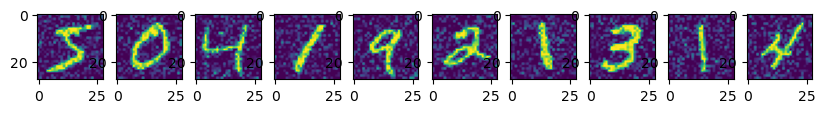

In [33]:
x_image_noise = tf.reshape(x_train_noise, [-1, 28, 28, 1])
x_image_noise = tf.cast(x_image_noise, 'float32')

f, a = plt.subplots(1, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[i].imshow(np.reshape(x_image_noise[i], (28, 28)))

### Custom model
Let's define a convolutional autoencoder, meaning it consists of convolutional layers

In [34]:
class Denoise(tf.keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [35]:
model = Denoise()
model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

Lets proceed to train the model using the noisy images as input and the original images as target

In [36]:
model.fit(x_train_noise, x_train,
            epochs=20,
            shuffle=True,
            validation_data=(x_test_noise, x_test))

Epoch 1/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0153 - val_loss: 0.0042
Epoch 2/20
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/20
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/20
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/20
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/20
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/20
1875/1875 [==============================] - 37s 20m

Let's now take a look at the summaries from the encoder and decoder. We can see that the images are first downsampled by the encoder from 28x28 to 7x7, and then reconstructed to their original shape by the decoder

In [38]:
model.encoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


We will now plot and compare the noisy images to the denoised images produced by the autoencoder

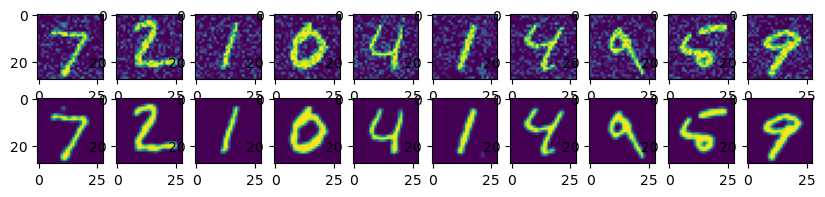

In [40]:
x_image_test = tf.reshape(x_test_noise, [-1, 28, 28, 1])
x_image_test = tf.cast(x_image_test, 'float32')

denoised = model(x_image_test[:examples_to_show])

f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_image_test[i], (28, 28)))
    a[1][i].imshow(np.reshape(denoised[i], (28, 28)))